# Lesson 17 — Reinforcement Learning I: MDPs, Value Functions, and Value Iteration (CS229-style)

This lesson follows Andrew Ng’s introduction to **Reinforcement Learning** via **Markov Decision Processes (MDPs)** and the canonical **gridworld robot** example.

We will:
- Define an MDP formally and connect it to the robot grid.
- Define **returns**, **discount factor** $\gamma$, **policy** $\pi$, and **value functions**.
- Derive the **Bellman expectation equation** and the **Bellman optimality equation**.
- Implement **value iteration** in **pure NumPy** and visualize:
  - value heatmaps
  - policy arrows
  - the effect of stochastic transitions (0.8 intended, 0.1 left, 0.1 right)
- Build a **robot simulator** that generates experience under an exploration policy.
- Show how exploration vs exploitation can go wrong (the “nearby +1 vs faraway +10” intuition).

**Implementation philosophy:** NumPy + Matplotlib only.

---

## Goals

By the end of this notebook you should be able to:

1. Translate a gridworld into an MDP $(\mathcal{S}, \mathcal{A}, P_{sa}, \gamma, R)$.
2. Compute $V^{\pi}(s)$ for a fixed policy and compute $V^*(s)$ and $\pi^*(s)$ via value iteration.
3. Understand how stochastic transitions change the optimal policy.
4. Simulate trajectories and diagnose when learning/exploration fails.


## 1) Big Picture: What RL is optimizing

In supervised learning, you often have pairs $(x^{(i)}, y^{(i)})$.

In reinforcement learning, you **do not** get the “correct action” at each step.
Instead, you define a **reward function** and the agent must discover a strategy that yields high long-run reward.

A common formalism is the **Markov Decision Process (MDP)**, defined as a 5-tuple:

$$
(\mathcal{S}, \mathcal{A}, P_{sa}, \gamma, R)
$$

- $\\mathcal{S}$: set of states  
- $\\mathcal{A}$: set of actions  
- $P_{sa}(s') = P(s_{t+1}=s' \\mid s_t=s, a_t=a)$: transition probabilities  
- $\\gamma \\in [0,1)$: discount factor  
- $R(s)$ or $R(s,a)$: reward function  

A **policy** $\\pi$ maps a state to an action (deterministic policy):

$$
\\pi : \\mathcal{S} \\to \\mathcal{A}
$$

When we “execute” a policy, we repeatedly:
1. observe $s_t$
2. take $a_t = \\pi(s_t)$
3. sample $s_{t+1} \\sim P_{s_t a_t}$
4. receive reward $r_{t+1} = R(s_{t+1})$ (this convention matches many gridworlds)

---

## 2) Discounted return and the value function

A trajectory produces rewards $r_1, r_2, \\dots$.

The (discounted) return from time $t$ is:

$$
G_t = \\sum_{k=0}^{\\infty} \\gamma^k r_{t+k+1}
$$

The **state-value function** under policy $\\pi$ is:

$$
V^{\\pi}(s) = \\mathbb{E}\\left[ G_t \\mid s_t = s, \\pi \\right]
$$

Intuition:
- $V^{\\pi}(s)$ is “how good it is” to start in state $s$ and then follow $\\pi$ forever.
- $\\gamma$ downweights distant rewards. Practically, it:
  - encourages reaching positive rewards sooner,
  - helps ensure $G_t$ is finite,
  - and often makes algorithms converge more reliably.

---

## 3) Bellman expectation equation

Expand the definition of $V^{\\pi}(s)$ by taking one step and then recursing:

$$
V^{\\pi}(s) = \\sum_{s'} P_{s\\pi(s)}(s') \\left( R(s') + \\gamma V^{\\pi}(s') \\right)
$$

This is the **Bellman expectation equation**.

---

## 4) Optimal value and Bellman optimality equation

Define the optimal value function:

$$
V^*(s) = \\max_{\\pi} V^{\\pi}(s)
$$

Then $V^*$ satisfies:

$$
V^*(s) = \\max_{a \\in \\mathcal{A}} \\sum_{s'} P_{sa}(s') \\left( R(s') + \\gamma V^*(s') \\right)
$$

Once you have $V^*$, an optimal policy is:

$$
\\pi^*(s) \\in \\arg\\max_{a \\in \\mathcal{A}} \\sum_{s'} P_{sa}(s') \\left( R(s') + \\gamma V^*(s') \\right)
$$

---

## 5) Value Iteration

Value iteration repeatedly applies the Bellman optimality backup:

$$
V_{k+1}(s) \\leftarrow \\max_{a} \\sum_{s'} P_{sa}(s') \\left( R(s') + \\gamma V_k(s') \\right)
$$

As $k \\to \\infty$, $V_k \\to V^*$ (under standard conditions, with $\\gamma < 1$).

We’ll implement this exactly for the gridworld robot.


In [101]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Matplotlib defaults: avoid clutter
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = False


## 6) The CS229 Gridworld Robot

We use the classic **3×4 grid** (rows × cols) with:
- a wall at position $(2,2)$ (using 1-indexed coordinates like the lecture)
- a terminal $+1$ at $(1,4)$
- a terminal $-1$ at $(2,4)$
- a small step cost (living penalty) of $-0.02$ everywhere else

Actions:

$$
\\mathcal{A} = \{\\text{N}, \\text{S}, \\text{E}, \\text{W}\\}
$$

Stochastic transitions (robot wheel slip):
- with probability $0.8$ go in the intended direction
- with probability $0.1$ slip to the **left** (relative to intended direction)
- with probability $0.1$ slip to the **right**

If the move would hit a wall or go out of bounds, the robot stays in place.

We will code this as an MDP and then run value iteration to recover the optimal policy.


In [102]:
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional

Action = int  # 0:N, 1:E, 2:S, 3:W
ACTIONS = [0, 1, 2, 3]
ACTION_NAMES = {0:"N", 1:"E", 2:"S", 3:"W"}

# For "left" and "right" relative turns
LEFT_OF  = {0:3, 1:0, 2:1, 3:2}  # N->W, E->N, S->E, W->S
RIGHT_OF = {0:1, 1:2, 2:3, 3:0}  # N->E, E->S, S->W, W->N

MOVE = {
    0: (-1, 0),  # N: row-1
    1: (0, +1),  # E: col+1
    2: (+1, 0),  # S: row+1
    3: (0, -1),  # W: col-1
}

@dataclass
class GridworldMDP:
    n_rows: int = 3
    n_cols: int = 4
    wall_rc: Tuple[int, int] = (1, 1)  # 0-indexed later; placeholder
    terminal_rewards: Dict[Tuple[int,int], float] = None  # (r,c)->reward
    living_reward: float = -0.02
    gamma: float = 0.95

    p_intended: float = 0.8
    p_left: float = 0.1
    p_right: float = 0.1

    def __post_init__(self):
        # Default terminals match lecture: +1 at (1,4), -1 at (2,4) in 1-indexed.
        if self.terminal_rewards is None:
            self.terminal_rewards = {(0, 3): +1.0, (1, 3): -1.0}
        # Wall at (2,2) in 1-indexed => (1,1) in 0-indexed.
        self.wall_rc = (1, 1)
        self._build_state_index()

    def _build_state_index(self):
        self.states = []
        for r in range(self.n_rows):
            for c in range(self.n_cols):
                if (r, c) == self.wall_rc:
                    continue
                self.states.append((r, c))
        self.s2i = {rc:i for i, rc in enumerate(self.states)}
        self.i2s = {i:rc for rc, i in self.s2i.items()}
        self.n_states = len(self.states)

        # Identify terminal indices
        self.terminal_state_mask = np.zeros(self.n_states, dtype=bool)
        for rc in self.terminal_rewards.keys():
            if rc in self.s2i:
                self.terminal_state_mask[self.s2i[rc]] = True

    def is_terminal(self, s_idx: int) -> bool:
        return self.terminal_state_mask[s_idx]

    def reward(self, s_idx: int) -> float:
        rc = self.i2s[s_idx]
        if rc in self.terminal_rewards:
            return float(self.terminal_rewards[rc])
        return float(self.living_reward)

    def step(self, s_idx: int, a: Action, rng: np.random.Generator) -> Tuple[int, float, bool]:
        # Terminal states are absorbing
        if self.is_terminal(s_idx):
            return s_idx, 0.0, True

        # Sample actual action due to slip
        u = rng.random()
        if u < self.p_intended:
            a_exec = a
        elif u < self.p_intended + self.p_left:
            a_exec = LEFT_OF[a]
        else:
            a_exec = RIGHT_OF[a]

        r, c = self.i2s[s_idx]
        dr, dc = MOVE[a_exec]
        r2, c2 = r + dr, c + dc

        # If invalid move, stay put
        if not (0 <= r2 < self.n_rows and 0 <= c2 < self.n_cols):
            s2_idx = s_idx
        elif (r2, c2) == self.wall_rc:
            s2_idx = s_idx
        else:
            s2_idx = self.s2i[(r2, c2)]

        rew = self.reward(s2_idx)
        done = self.is_terminal(s2_idx)
        return s2_idx, rew, done

    def transition_probs(self, s_idx: int, a: Action) -> Dict[int, float]:
        """Return a dict of next_state_idx -> prob for taking action a in s."""
        if self.is_terminal(s_idx):
            return {s_idx: 1.0}

        outcomes = [
            (a, self.p_intended),
            (LEFT_OF[a], self.p_left),
            (RIGHT_OF[a], self.p_right),
        ]

        probs = {}
        r, c = self.i2s[s_idx]
        for a_exec, p in outcomes:
            dr, dc = MOVE[a_exec]
            r2, c2 = r + dr, c + dc

            if not (0 <= r2 < self.n_rows and 0 <= c2 < self.n_cols) or (r2, c2) == self.wall_rc:
                s2_idx = s_idx
            else:
                s2_idx = self.s2i[(r2, c2)]
            probs[s2_idx] = probs.get(s2_idx, 0.0) + p

        return probs

mdp = GridworldMDP()
print("Number of valid states:", mdp.n_states)
print("Terminal states:", [mdp.i2s[i] for i in range(mdp.n_states) if mdp.is_terminal(i)])


Number of valid states: 11
Terminal states: [(0, 3), (1, 3)]


## 7) Value Iteration (NumPy)

We implement the Bellman optimality backup:

$$
V_{k+1}(s) \\leftarrow \\max_{a} \\sum_{s'} P_{sa}(s') \\left( R(s') + \\gamma V_k(s') \\right)
$$

Diagnostics we care about:
- The max change $\\|V_{k+1} - V_k\\|_{\\infty}$ should go to 0.
- Terminal states should remain fixed (absorbing in our step model).


In [103]:
def value_iteration(mdp: GridworldMDP, tol: float = 1e-9, max_iters: int = 10_000):
    V = np.zeros(mdp.n_states, dtype=np.float64)

    for it in range(max_iters):
        V_new = V.copy()

        for s in range(mdp.n_states):
            if mdp.is_terminal(s):
                # Convention: terminal state's value is 0 future reward once entered,
                # but the reward is received upon transitioning *into* terminal.
                # So we keep V(terminal)=0 here.
                V_new[s] = 0.0
                continue

            q_vals = []
            for a in ACTIONS:
                p_next = mdp.transition_probs(s, a)
                q = 0.0
                for s2, p in p_next.items():
                    q += p * (mdp.reward(s2) + mdp.gamma * V[s2])
                q_vals.append(q)
            V_new[s] = max(q_vals)

        delta = np.max(np.abs(V_new - V))
        V = V_new
        if (it+1) % 25 == 0 or it == 0:
            print(f"iter {it+1:4d} | max delta = {delta:.6e}")
        if delta < tol:
            print(f"Converged in {it+1} iterations with delta={delta:.3e}")
            break

    # Extract greedy policy
    pi = np.zeros(mdp.n_states, dtype=np.int64)
    for s in range(mdp.n_states):
        if mdp.is_terminal(s):
            pi[s] = -1
            continue
        best_a, best_q = None, -1e18
        for a in ACTIONS:
            p_next = mdp.transition_probs(s, a)
            q = sum(p * (mdp.reward(s2) + mdp.gamma * V[s2]) for s2, p in p_next.items())
            if q > best_q:
                best_q, best_a = q, a
        pi[s] = best_a

    return V, pi

V_star, pi_star = value_iteration(mdp, tol=1e-10, max_iters=5000)
V_star, pi_star[:5], V_star.shape


(array([0.77956774, 0.86627249, 0.94957989, 0.        , 0.70675492,
        0.66705051, 0.        , 0.63097273, 0.56733244, 0.57428404,
        0.35188494]),
 array([ 1,  1,  1, -1,  0]),
 (11,))

## 8) Visualizing the Value Function and the Optimal Policy

We will draw:
- a **value heatmap** over the grid
- an **arrow policy map** (like the lecture)
- mark terminals and the wall clearly

Remember:
- color encodes the value $V(s)$
- arrows encode the greedy action under $\\pi^*(s)$


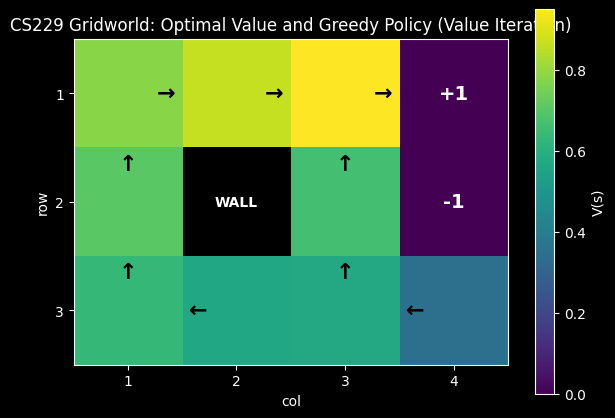

In [104]:
def to_grid(mdp: GridworldMDP, arr_state):
    """Map a length-|S| vector to a (n_rows, n_cols) array with NaN for wall."""
    G = np.full((mdp.n_rows, mdp.n_cols), np.nan, dtype=np.float64)
    for s_idx, (r,c) in mdp.i2s.items():
        G[r,c] = arr_state[s_idx]
    return G

ARROW = {0:(0, -0.35, "↑"), 1:(0.35, 0, "→"), 2:(0, 0.35, "↓"), 3:(-0.35, 0, "←")}

def plot_value_and_policy(mdp: GridworldMDP, V: np.ndarray, pi: np.ndarray, title: str):
    Vg = to_grid(mdp, V)
    fig, ax = plt.subplots(figsize=(7,5))
    im = ax.imshow(Vg, origin="upper")
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("V(s)")

    # Gridlines
    ax.set_xticks(np.arange(mdp.n_cols))
    ax.set_yticks(np.arange(mdp.n_rows))
    ax.set_xticklabels(np.arange(1, mdp.n_cols+1))
    ax.set_yticklabels(np.arange(1, mdp.n_rows+1))
    ax.set_xlabel("col")
    ax.set_ylabel("row")
    ax.set_title(title)

    # Annotate terminals and wall
    wr, wc = mdp.wall_rc
    ax.text(wc, wr, "WALL", ha="center", va="center", color="white", fontsize=10, fontweight="bold")

    for (r,c), rew in mdp.terminal_rewards.items():
        ax.text(c, r, f"{rew:+.0f}", ha="center", va="center", color="white", fontsize=14, fontweight="bold")

    # Policy arrows
    for s in range(mdp.n_states):
        if mdp.is_terminal(s):
            continue
        r,c = mdp.i2s[s]
        a = pi[s]
        if a == -1:
            continue
        dx, dy, sym = ARROW[a]
        ax.text(c+dx, r+dy, sym, ha="center", va="center", color="black", fontsize=16, fontweight="bold")

    ax.set_xlim(-0.5, mdp.n_cols-0.5)
    ax.set_ylim(mdp.n_rows-0.5, -0.5)
    plt.show()

plot_value_and_policy(mdp, V_star, pi_star, title="CS229 Gridworld: Optimal Value and Greedy Policy (Value Iteration)")


## 9) Robot Simulation: Executing a Policy

Value iteration gives you an optimal *plan* for the MDP model.

Now we simulate the robot moving in the grid, showing:
- stochastic slips
- terminal absorption
- the realized return along a trajectory

This helps with sanity checks:
- Does following $\\pi^*$ usually reach $+1$?
- Do occasional slips cause the robot to fall into $-1$?


In [105]:
def rollout(mdp: GridworldMDP, start_rc=(2,0), pi=None, max_steps=200, seed=0):
    rng = np.random.default_rng(seed)
    s = mdp.s2i[start_rc]
    traj = [s]
    rewards = []
    done = False
    for t in range(max_steps):
        if mdp.is_terminal(s):
            done = True
            break
        a = pi[s] if pi is not None else rng.choice(ACTIONS)
        s2, r, done2 = mdp.step(s, a, rng)
        traj.append(s2)
        rewards.append(r)
        s = s2
        if done2:
            done = True
            break

    # compute discounted return from start
    G = 0.0
    for k, r in enumerate(rewards):
        G += (mdp.gamma**k) * r
    return traj, rewards, G, done

def pretty_traj(mdp: GridworldMDP, traj):
    return [mdp.i2s[s] for s in traj]

traj, rewards, G, done = rollout(mdp, start_rc=(2,0), pi=pi_star, max_steps=50, seed=1)
print("done:", done, "steps:", len(rewards), "return:", G)
print("trajectory (row,col):", pretty_traj(mdp, traj))


done: True steps: 9 return: 0.5287886038046873
trajectory (row,col): [(2, 0), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0), (0, 1), (0, 1), (0, 2), (0, 3)]


## 10) Exploration vs Exploitation (Conceptual Failure Mode)

A classic RL pitfall:

- Suppose the robot starts near a small, easy reward (say $+1$).
- Far away, there is a much larger reward (say $+10$).
- If the robot’s learning is greedy too early, it will repeatedly exploit the nearby $+1$
  and **never** discover the far $+10$.

This is why exploration strategies exist:
- $\\epsilon$-greedy
- softmax action selection
- optimistic initialization
- UCB-style bonuses (later topics)

In this lesson, we’ll simulate an $\\epsilon$-greedy explorer on a larger grid and show
how too-small $\\epsilon$ leads to “getting stuck” near local reward.


In [106]:
@dataclass
class LargeGridMDP(GridworldMDP):
    n_rows: int = 8
    n_cols: int = 8
    def __post_init__(self):
        # No internal wall for this demo; keep a dummy wall outside grid
        self.wall_rc = (-1, -1)
        # Put +10 in bottom-left, +1 near start
        self.terminal_rewards = {(0,0): +10.0, (3,7): +1.0}
        self.living_reward = -0.02
        self.gamma = 0.80
        self.p_intended, self.p_left, self.p_right = 0.8, 0.1, 0.1
        self._build_state_index()
        self.start = (3, 6)

lg = LargeGridMDP()

def epsilon_greedy_action(q_s, eps, rng):
    if rng.random() < eps:
        return rng.integers(0, 4)
    return int(np.argmax(q_s))

def q_from_V(mdp, V):
    Q = np.zeros((mdp.n_states, 4), dtype=np.float64)
    for s in range(mdp.n_states):
        for a in ACTIONS:
            p_next = mdp.transition_probs(s, a)
            Q[s,a] = sum(p*(mdp.reward(s2) + mdp.gamma*V[s2]) for s2,p in p_next.items())
    return Q

# We'll do model-based learning: estimate transition probabilities from experience,
# then re-run value iteration on the estimated model periodically.
def learn_transitions_model_based(mdp: GridworldMDP, start_rc, eps=0.05, episodes=200, max_steps=200, replan_every=10, seed=0):
    rng = np.random.default_rng(seed)
    m, n = mdp.n_states, 4

    # Count transitions N[s,a,s']
    N = np.zeros((m, n, m), dtype=np.int64)
    # Track how often we took (s,a)
    Na = np.zeros((m, n), dtype=np.int64)

    # Start with a pessimistic model: self-loop everywhere
    P_hat = np.zeros((m, n, m), dtype=np.float64)
    for s in range(m):
        for a in range(n):
            P_hat[s,a,s] = 1.0

    def value_iteration_from_P(P_hat, mdp, tol=1e-9, max_iters=5000):
        V = np.zeros(mdp.n_states, dtype=np.float64)
        for _ in range(max_iters):
            V_new = V.copy()
            for s in range(mdp.n_states):
                if mdp.is_terminal(s):
                    V_new[s] = 0.0
                    continue
                q = np.zeros(4)
                for a in ACTIONS:
                    # sum over s'
                    r_next = np.array([mdp.reward(s2) for s2 in range(mdp.n_states)])
                    q[a] = (P_hat[s,a] @ (r_next + mdp.gamma*V))
                V_new[s] = np.max(q)
            if np.max(np.abs(V_new - V)) < tol:
                V = V_new
                break
            V = V_new

        # Greedy policy
        Q = np.zeros((mdp.n_states, 4), dtype=np.float64)
        r_next = np.array([mdp.reward(s2) for s2 in range(mdp.n_states)])
        for s in range(mdp.n_states):
            for a in ACTIONS:
                Q[s,a] = P_hat[s,a] @ (r_next + mdp.gamma*V)
        pi = np.argmax(Q, axis=1)
        pi[mdp.terminal_state_mask] = -1
        return V, pi, Q

    V_est, pi_est, Q_est = value_iteration_from_P(P_hat, mdp)

    total_returns = []
    reached_big = 0
    reached_small = 0

    for ep in range(1, episodes+1):
        s = mdp.s2i[start_rc]
        ep_rewards = []
        done = False

        for t in range(max_steps):
            if mdp.is_terminal(s):
                done = True
                break

            a = epsilon_greedy_action(Q_est[s], eps, rng)
            s2, r, done2 = mdp.step(s, a, rng)
            ep_rewards.append(r)

            # update counts
            N[s,a,s2] += 1
            Na[s,a] += 1

            # update P_hat row for (s,a)
            P_hat[s,a] = N[s,a] / max(1, Na[s,a])

            s = s2
            if done2:
                done = True
                break

        # compute return
        G = 0.0
        for k, r in enumerate(ep_rewards):
            G += (mdp.gamma**k) * r
        total_returns.append(G)

        # bookkeeping: which terminal did we hit?
        if done and mdp.i2s[s] in mdp.terminal_rewards:
            if mdp.terminal_rewards[mdp.i2s[s]] > 5:
                reached_big += 1
            else:
                reached_small += 1

        # re-plan periodically
        if ep % replan_every == 0:
            V_est, pi_est, Q_est = value_iteration_from_P(P_hat, mdp)

    stats = {
        "returns": np.array(total_returns),
        "reached_big": reached_big,
        "reached_small": reached_small,
        "P_hat": P_hat,
        "V_est": V_est,
        "pi_est": pi_est
    }
    return stats

eps_sm=0.01
eps_md=0.2
eps_bg=0.45

stats_small_eps  = learn_transitions_model_based(lg, start_rc=lg.start, eps=eps_sm, episodes=200, replan_every=10, seed=0)
stats_medium_eps = learn_transitions_model_based(lg, start_rc=lg.start, eps=eps_md, episodes=200, replan_every=10, seed=1)
stats_big_eps    = learn_transitions_model_based(lg, start_rc=lg.start, eps=eps_bg, episodes=200, replan_every=10, seed=1)

print(f"eps={eps_sm} | reached +10:", stats_small_eps["reached_big"], "reached +1:", stats_small_eps["reached_small"])
print(f"eps={eps_md}| reached +10:", stats_medium_eps["reached_big"], "reached +1:", stats_medium_eps["reached_small"])
print(f"eps={eps_bg} | reached +10:", stats_big_eps["reached_big"], "reached +1:", stats_big_eps["reached_small"])


eps=0.01 | reached +10: 173 reached +1: 21
eps=0.2| reached +10: 153 reached +1: 41
eps=0.45 | reached +10: 142 reached +1: 56


### Returns over episodes: too little exploration vs enough exploration

We plot discounted return per episode for two settings:
- $\\epsilon = 0.01$ (very exploitative)
- $\\epsilon = 0.20$ (in between)
- $\\epsilon = 0.45$ (very exploratory)

You should see the higher-exploration run discover the $+10$ state more often, producing larger returns.


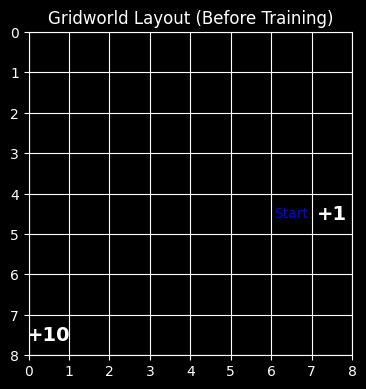

In [107]:
def plot_gridworld_layout(rows, cols, wall=None, terminals=None, start=None, title="Gridworld Layout (Before Training)"):
    """
    Draws the static gridworld layout:
      - wall cell (blocked)
      - terminal reward labels
      - start state label
    Coordinates are (r, c) with r=0 at top row, c=0 at left column.
    """
    terminals = terminals or {}  # {(r,c): reward}

    fig, ax = plt.subplots(figsize=(5.2, 4.2))
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_xticks(range(cols + 1))
    ax.set_yticks(range(rows + 1))
    ax.grid(True)
    ax.set_aspect("equal")

    # Draw wall
    if wall is not None:
        wr, wc = wall
        ax.add_patch(plt.Rectangle((wc, rows - 1 - wr), 1, 1, color="black"))

    # Terminal labels
    for (r, c), rew in terminals.items():
        ax.text(
            c + 0.5, rows - 1 - r + 0.5,
            f"{rew:+.0f}",
            ha="center", va="center",
            fontsize=14, fontweight="bold"
        )

    # Start label
    if start is not None:
        sr, sc = start
        ax.text(
            sc + 0.5, rows - 1 - sr + 0.5,
            "Start",
            ha="center", va="center",
            fontsize=10, color="blue"
        )

    ax.set_title(title)
    ax.invert_yaxis()
    plt.show()

plot_gridworld_layout(lg.n_rows, lg.n_cols, lg.wall_rc, lg.terminal_rewards, start=lg.start)

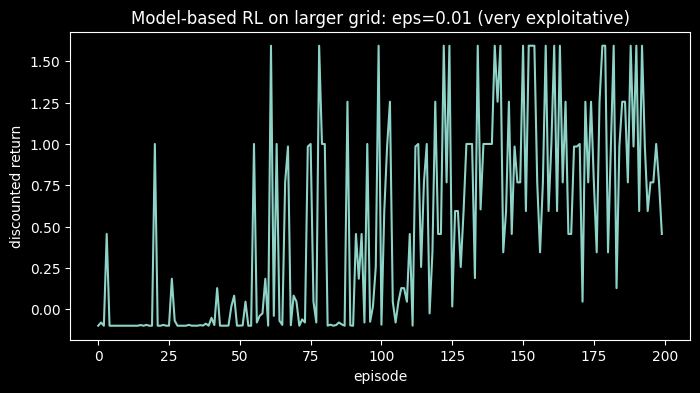

In [108]:
def plot_returns(stats, title):
    R = stats["returns"]
    plt.figure(figsize=(8,4))
    plt.plot(R)
    plt.xlabel("episode")
    plt.ylabel("discounted return")
    plt.title(title)
    plt.show()

plot_returns(stats_small_eps, "Model-based RL on larger grid: eps=0.01 (very exploitative)")

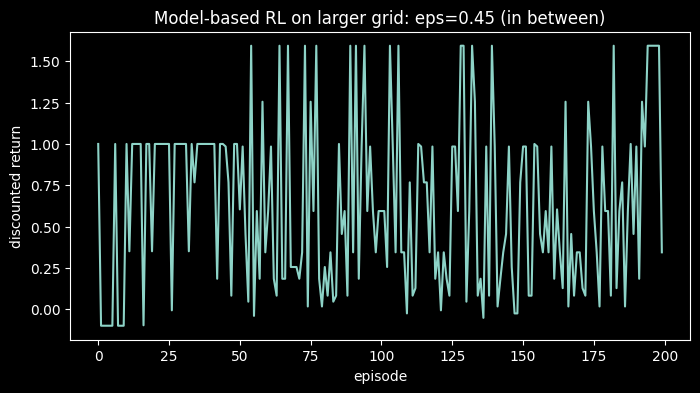

In [109]:
plot_returns(stats_medium_eps, "Model-based RL on larger grid: eps=0.45 (in between)")

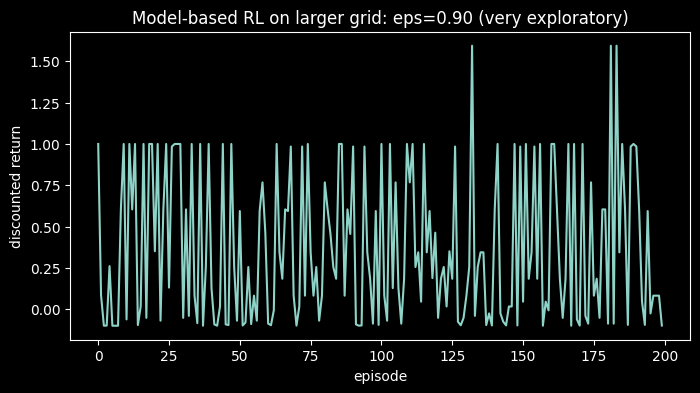

In [110]:
plot_returns(stats_big_eps,   "Model-based RL on larger grid: eps=0.90 (very exploratory)")

## 11) Diagnostics / Sanity Checks

When your gridworld RL code “doesn’t work”, the failure is usually one of these:

1. **Reward convention mismatch**
   - Reward on *entering* $s'$ vs reward on *leaving* $s$
2. **Terminal handling**
   - Is the terminal absorbing?
   - Do you double-count terminal reward?
3. **Transition model mismatch**
   - 0.8/0.1/0.1 slip defined relative to intended direction?
4. **Value iteration bug**
   - Not using $\\gamma$
   - Not maximizing over actions
5. **Exploration too small**
   - Learner never visits key states so $\\hat P$ is garbage there.

Below are small checks we can run quickly.


In [111]:
# 1) Transition probabilities sum to 1
s0 = mdp.s2i[(2,0)]
for a in ACTIONS:
    p = mdp.transition_probs(s0, a)
    print(ACTION_NAMES[a], "sum p =", sum(p.values()))

# 2) Terminal is absorbing in transition model
term = mdp.s2i[(0,3)]
print("terminal transitions:", mdp.transition_probs(term, 0))

# 3) Reward at terminal states (as 'entered' reward convention)
print("reward(+1 state):", mdp.reward(mdp.s2i[(0,3)]))
print("reward(-1 state):", mdp.reward(mdp.s2i[(1,3)]))


N sum p = 1.0
E sum p = 1.0
S sum p = 1.0
W sum p = 1.0
terminal transitions: {3: 1.0}
reward(+1 state): 1.0
reward(-1 state): -1.0


In [112]:
import numpy as np
import matplotlib.pyplot as plt

A_UP, A_RIGHT, A_DOWN, A_LEFT = 0, 1, 2, 3
ARROW = {A_UP: "↑", A_RIGHT: "→", A_DOWN: "↓", A_LEFT: "←"}

def plot_value_and_policy(
    V,
    policy=None,
    wall=None,
    terminals=None,
    title="Value and Policy",
    show_colorbar=True,
    vmin=None,
    vmax=None,
):
    """
    Heatmap for V(s) + optional policy arrows.
    Coordinates are (r, c) with r=0 at top row.
    - V: (rows, cols) values, use np.nan for wall or invalid states
    - policy: (rows, cols) int actions or None
    - wall: (r, c) or None
    - terminals: {(r,c): reward} or None
    """
    terminals = terminals or {}
    rows, cols = V.shape

    # Mask out NaNs so imshow ignores them in color scaling
    V_plot = np.array(V, dtype=float)
    mask = np.isnan(V_plot)
    V_masked = np.ma.array(V_plot, mask=mask)

    fig, ax = plt.subplots(figsize=(6.2, 4.8))

    im = ax.imshow(
        V_masked,
        origin="upper",
        interpolation="nearest",
        vmin=vmin,
        vmax=vmax,
    )

    # Grid lines
    ax.set_xticks(np.arange(-0.5, cols, 1))
    ax.set_yticks(np.arange(-0.5, rows, 1))
    ax.grid(True)
    ax.set_xticks([])
    ax.set_yticks([])

    # Colorbar
    if show_colorbar:
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("V(s)")

    # Draw wall (overlay)
    if wall is not None:
        wr, wc = wall
        ax.add_patch(plt.Rectangle((wc - 0.5, wr - 0.5), 1, 1, color="black", zorder=3))

    # Annotate each cell with value and optionally arrow
    for r in range(rows):
        for c in range(cols):
            if wall is not None and (r, c) == wall:
                continue

            if (r, c) in terminals:
                # Terminal: show reward, no arrow
                ax.text(
                    c, r,
                    f"T\n{terminals[(r,c)]:+.0f}",
                    ha="center", va="center",
                    fontsize=11, fontweight="bold",
                    color="white" if not np.isnan(V_plot[r,c]) and V_plot[r,c] < (np.nanmax(V_plot) if np.isfinite(np.nanmax(V_plot)) else 0) else "black",
                    zorder=4
                )
                continue

            if np.isnan(V_plot[r, c]):
                continue

            # Value text
            ax.text(
                c, r,
                f"{V_plot[r,c]:.2f}",
                ha="center", va="center",
                fontsize=9,
                zorder=4
            )

            # Arrow overlay
            if policy is not None and policy[r, c] is not None:
                a = int(policy[r, c])
                if a in ARROW:
                    ax.text(
                        c, r + 0.28,  # slight offset so it doesn't collide with value
                        ARROW[a],
                        ha="center", va="center",
                        fontsize=16,
                        color="white",
                        zorder=5
                    )

    ax.set_title(title)
    plt.show()

In [113]:
# Example: define these from your code
# V_init, V_after_1, V_star are (rows, cols)
# pi_star is (rows, cols) with actions 0/1/2/3 (or None for terminals/walls)

plot_value_and_policy(
    V_after_1,
    policy=None,
    wall=wall,
    terminals=terminals,
    title="Value Iteration: V(s) after 1 sweep (no policy yet)"
)

plot_value_and_policy(
    V_star,
    policy=None,
    wall=wall,
    terminals=terminals,
    title="Value Iteration: V*(s) after convergence (values only)"
)

plot_value_and_policy(
    V_star,
    policy=pi_star,
    wall=wall,
    terminals=terminals,
    title="Optimal Value V*(s) + Greedy Optimal Policy π*(s)"
)

NameError: name 'V_after_1' is not defined

## Key Takeaways (Lesson 17)

### When to use this framework
- Use an **MDP** when:
  - the environment is sequential,
  - actions influence future states,
  - and the Markov property is a reasonable approximation (the future depends on the present state, not the full history).
- Use **value iteration** when:
  - you have a known model $P_{sa}$ and reward $R$ (or you can estimate them),
  - the state space is small enough for tabular dynamic programming.

### What this lesson actually computed
- We computed **$V^*(s)$** and a greedy optimal policy **$\\pi^*(s)$** for the gridworld by repeatedly applying the **Bellman optimality backup**:
  $$
  V_{k+1}(s) \\leftarrow \\max_{a} \\sum_{s'} P_{sa}(s') \\left(R(s') + \\gamma V_k(s')\\right)
  $$
- This is **planning** (solving the MDP), not “learning from data”.
  The algorithm assumes you know $P_{sa}$ and $R$ exactly.

### Failure modes (what breaks first)
1. **Reward placement convention**
   - If you accidentally use $R(s)$ instead of $R(s')$ (or vice versa), your value function and policy can change noticeably.
   - In gridworlds, the common convention is “reward upon entering the next cell”.
2. **Terminal handling**
   - Double-counting terminal rewards is common:
     - if you give reward for entering terminal and also keep giving terminal reward forever, values can blow up.
   - A clean convention is:
     - reward when entering terminal,
     - then terminal has no future reward ($V(terminal)=0$).
3. **Transition slip geometry**
   - “Left” and “right” are **relative** to the intended direction.
   - If you implement absolute left/right (west/east) by mistake, the optimal policy changes.
4. **Numeric convergence**
   - If $\\gamma$ is close to 1 and you have tiny step costs, value iteration may require many iterations.
   - Use $\\|V_{k+1}-V_k\\|_\\infty$ as a clear stopping diagnostic.
5. **Exploration failure**
   - In the large-grid example, small $\\epsilon$ means the agent may never discover high-value regions.
   - The model estimate $\\hat P$ stays wrong where you never visit.

### Bias–variance behavior (in RL terms)
In tabular planning with known $P_{sa}$, there is effectively **no statistical variance**: you are computing the exact solution.

But in learning settings (estimating $\\hat P_{sa}$ from data):
- **Bias** comes from:
  - incorrect model class (e.g., assuming Markov when it is not),
  - reward misspecification,
  - insufficient exploration (systematically missing parts of the state space).
- **Variance** comes from:
  - finite samples: transition probabilities estimated from few visits fluctuate,
  - stochastic policies and stochastic dynamics.

A useful mental model:
- early on, the agent’s policy induces a data distribution that can be extremely biased.
- many RL instabilities are really “dataset shift” problems created by the agent itself.

### Practical diagnostics you should always run
- Check that for every $(s,a)$, $\\sum_{s'} P_{sa}(s') = 1$.
- Visualize:
  - value heatmaps
  - policy arrows
  - rollouts on the grid
- For learning:
  - count visitation frequency per state
  - measure how often you reach each terminal reward
  - plot returns across episodes (should trend upward if learning is working)

### Connections to later lessons (18–19)
- Lesson 18 typically extends this to:
  - **continuous state spaces**, discretization, and function approximation.
  - simulation (model-based RL) and why simulators should often be stochastic.
- Lesson 19 often introduces:
  - deeper exploration concepts,
  - model-free ideas (e.g., Q-learning / TD learning),
  - and formalizing the transition model $P(s'\\mid s,a)$ and learning it from experience.

### What to do next
- Replace the model-based learner here with:
  - **TD(0) policy evaluation**,
  - **Q-learning**,
  - or **SARSA**.
- Compare:
  - planning with known $P_{sa}$ vs learning without it,
  - and watch how exploration becomes essential.
